In [1]:

from parse_data import get_data, get_modified_values, get_binary_values, make_data_scalar
from rnn_layers import PredictTime
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)

df = get_data()

Using device:  cuda


In [2]:

def make_data(df, device):

    x_train, y_train = [], []
    prev = None

    for row in df:
        if prev is None:
            prev = row
        x_train.append(prev)
        y_train.append(row)
        prev = row
    print(x_train[0].size())
    return torch.stack(x_train).float().to(device),torch.stack(y_train).float().to(device)

make_data(get_binary_values(get_data()), device)



torch.Size([1])


(tensor([[1.],
         [1.],
         [0.],
         ...,
         [1.],
         [0.],
         [1.]], device='cuda:0'),
 tensor([[1.],
         [0.],
         [1.],
         ...,
         [0.],
         [1.],
         [1.]], device='cuda:0'))

In [3]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
from IPython.display import clear_output
import torch.nn as nn
import random

batch_size = 100
x_d, y_d = make_data(get_binary_values(get_data()), device)


print(y_d.size(), x_d.size())

model = PredictTime(input_size=x_d[0].size()[0],
                    output_size=y_d[0].size()[0],
                    hidden_layers=1,
                    hidden_size=25, device=device).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.01)

loss = nn.BCELoss()
loader = data.DataLoader(data.TensorDataset(x_d,y_d), batch_size=batch_size)
epochs = 1000
for e in range(epochs):
    model.train()
    #print(next(iter(loader)))
    model.clean_state()
    res = []
    
    
    #if random.random() < e/(epochs*2):
        #model.teacher_forcing = False
    #else:
       # model.teacher_forcing = True
    
    for x, y in loader:
        
        if random.random() < 0.5:
            continue
        model.random_state()
        
        
        y_pred = model(x)
        l = loss(y_pred, y)
        res.append(l)
        #print(y_pred, y)
    
    
    l = res[0]
    for i in res[1:]:
        l += i
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    if e % 10 != 0:
        continue
    #clear_output(wait=True)
    sum_loss = 0
    #print(list(model.parameters())[-1])

    for x, y in loader:
        model.eval()
        with torch.no_grad():
            y_pred = model(x)
            sum_loss += np.sqrt(loss(y_pred, y).cpu())
    
    print("Epoch %d Loss %.4f" % (e, sum_loss))
    
    
#for d in df.values:

torch.Size([1])
torch.Size([8152, 1]) torch.Size([8152, 1])
Epoch 0 Loss 67.8570
Epoch 10 Loss 65.3120
Epoch 20 Loss 64.6247
Epoch 30 Loss 64.1639
Epoch 40 Loss 63.8010
Epoch 50 Loss 63.6134
Epoch 60 Loss 63.4463
Epoch 70 Loss 63.4889
Epoch 80 Loss 63.4082
Epoch 90 Loss 63.4813
Epoch 100 Loss 63.4678
Epoch 110 Loss 63.4175
Epoch 120 Loss 63.4010
Epoch 130 Loss 63.3851
Epoch 140 Loss 63.4673
Epoch 150 Loss 63.4273
Epoch 160 Loss 63.4215
Epoch 170 Loss 63.3626
Epoch 180 Loss 63.3696
Epoch 190 Loss 63.3678
Epoch 200 Loss 63.4221
Epoch 210 Loss 63.3289
Epoch 220 Loss 63.3474
Epoch 230 Loss 63.3196
Epoch 240 Loss 63.3445
Epoch 250 Loss 63.3021
Epoch 260 Loss 63.2976
Epoch 270 Loss 63.3026
Epoch 280 Loss 63.2797
Epoch 290 Loss 63.3112
Epoch 300 Loss 63.3203
Epoch 310 Loss 63.3010
Epoch 320 Loss 63.3632
Epoch 330 Loss 63.3656
Epoch 340 Loss 63.3574
Epoch 350 Loss 63.3009
Epoch 360 Loss 63.2598
Epoch 370 Loss 63.2808
Epoch 380 Loss 63.2793
Epoch 390 Loss 63.3090
Epoch 400 Loss 63.3855
Epoch 41

tensor(0.9034)


/opt/conda/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/opt/conda/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


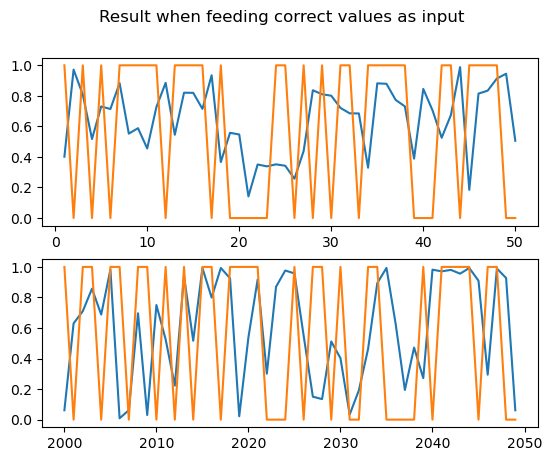

In [4]:
import matplotlib.pyplot as plt

def eval_model(x,y,m):
    df = get_data() 
    maxtime = df.max()[1]

    res = []
    m.eval()
    m.clean_state()
    count  = 1
    prev = x[0][0]
    for i in x:
        t = torch.tensor([[prev]]).to(device)
        prev = i
        val = m(t)
        count += 1
        res.append(val.detach().cpu()[0])
    
    loss = nn.BCELoss()
    print(np.sqrt(loss(torch.tensor(res).to(device),y.squeeze()).cpu()))
    

    fig, ax = plt.subplots(2)
    
    ax[0].plot(range(1,51), res[:50])
    ax[0].plot( range(1,51), y[:50].cpu())

    ax[1].plot(range(2000,2050), res[2000:2050])
    
    ax[1].plot(range(2000,2050), y[2000:2050].cpu() )
    fig.suptitle("Result when feeding correct values as input")
    fig.savefig("teacher_forcing.png")


amount = 1000
eval_model(x_d,y_d,model)


tensor(0.8252)


/opt/conda/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/opt/conda/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


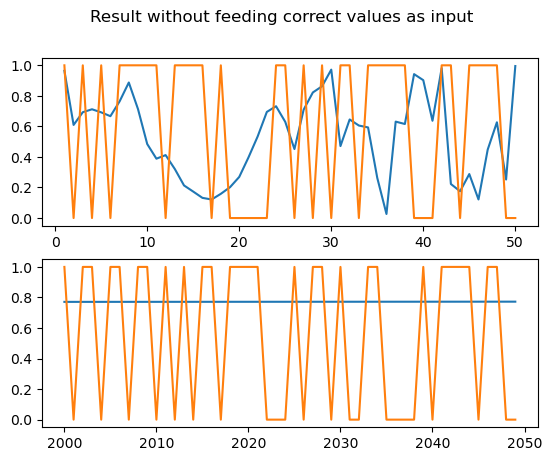

In [5]:
import matplotlib.pyplot as plt

def eval_model(x,y,m):
    df = get_data() 
    maxtime = df.max()[1]

    res = []
    m.eval()
    m.clean_state()
    count  = 1
    prev = x[0][0]
    for i in x:
        t = torch.tensor([[prev]]).to(device)
        prev = i
        val = m(t)
        prev = val
        count += 1
        res.append(val.detach().cpu()[0])
    
    loss = nn.BCELoss()
    print(np.sqrt(loss(torch.tensor(res).to(device),y.squeeze()).cpu()))
    
    fig, ax = plt.subplots(2)
    
    ax[0].plot(range(1,51), res[:50])
    ax[0].plot( range(1,51), y[:50].cpu())

    ax[1].plot(range(2000,2050), res[2000:2050])
    
    ax[1].plot(range(2000,2050), y[2000:2050].cpu() )
    fig.suptitle("Result without feeding correct values as input")
    fig.savefig("teacher_forcing_not_correct.png")
    
amount = 1000
eval_model(x_d,y_d,model)
